# VSB Powerline - augmented

full time series augmentation using recombined time shifted signals

image size 600, resnet 34 (preliminary) and resnet 50 (post cmap analysis - see vsb_spectrogram_sz600_cmap_tests_20190124.ipynb)

resnet loss too noisy, tried a lot of different lr's

here we try densenet121 - far more stable

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.41.dev0


In [6]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [7]:
DATE

'20190126'

In [8]:
UID

'4de28ccd'

In [9]:
MODEL_NAME='600_ts_aug'

In [11]:
image_size=600
bs = 8  #16 too large

In [12]:
path = Path('../input/')
train_path = path/'train_600_ts_aug_viridis-70-20/'

In [13]:
test_path = path/'test_600_ts_viridis-70-20/'

In [14]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [15]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [16]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [17]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [18]:
train_files = [f for f in listdir(str(train_path)) if isfile(join(str(train_path), f))]

In [19]:
for f in train_files:
    end = f.split('.')[1]
    assert end == 'jpg'

In [20]:
aug_sig_names=[]
sigs=[]
for f in train_files:
    f_name=f.split('.jpg')[0]
    if '_' in f_name:
        sigs.append(f_name.split('_')[0])
        aug_sig_names.append(f_name)

In [21]:
len(aug_sig_names)

6984

In [22]:
idms=[]
phases=[]
targets=[]
for f, s in zip(aug_sig_names, sigs):
    row = train_df.loc[train_df['signal_id'] == int(s)]
    assert row is not None
    idms.append(row['id_measurement'].values[0])
    phases.append(row['phase'].values[0])
    targets.append(row['target'].values[0])

In [23]:
aug_df = pd.DataFrame([aug_sig_names, idms, phases, targets])

In [24]:
aug_df=aug_df.T


In [25]:
aug_df.columns=['signal_id','id_measurement','phase','target']

In [26]:
aug_df.head()

,signal_id,id_measurement,phase,target
0,6278_neg_aug_875,2092,2,1
1,5284_neg_aug_75,1761,1,1
2,709_neg_aug_50,236,1,1
3,2418_pos_aug_625,806,0,1
4,5983_neg_aug_125,1994,1,1


In [27]:
train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [28]:
len(train_df)

15696

In [29]:
train_df.describe()

,signal_id,id_measurement,phase,target
count,15696,15696,15696,15696
unique,15696,2904,3,2
top,1265_pos_aug_625,1451,2,0
freq,1,39,5232,8871


### Image Data

In [30]:
tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.05, max_warp=0, p_lighting=0.1, xtra_tfms=[jitter(magnitude=.0001)])

In [30]:
data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg')

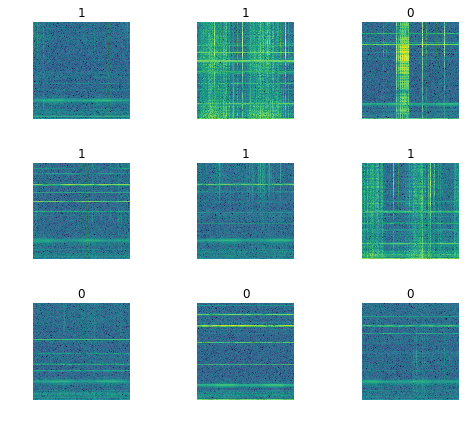

In [31]:
data.show_batch(rows=3, figsize=(7,6))

In [32]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

## Training: resnet34

In [33]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

### use 2x GPU's

This fails using 1x GPU and a bs of 2 - try with larger bs

In [34]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


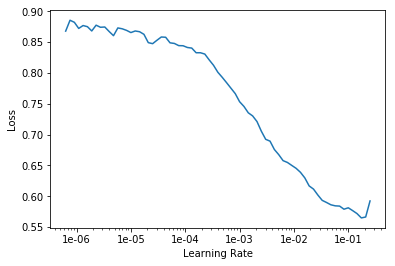

In [36]:
learn.recorder.plot()

#### fit

In [46]:
lr=1e-3

In [37]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,error_rate
1,0.337254,0.231514,0.091272
2,0.218018,0.162169,0.059294
3,0.164109,0.119198,0.038641
4,0.112628,0.104225,0.031979
5,0.090774,0.101710,0.034644


In [38]:
learn.save(f'{MODEL_NAME}_stage-1')

## Results

In [39]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

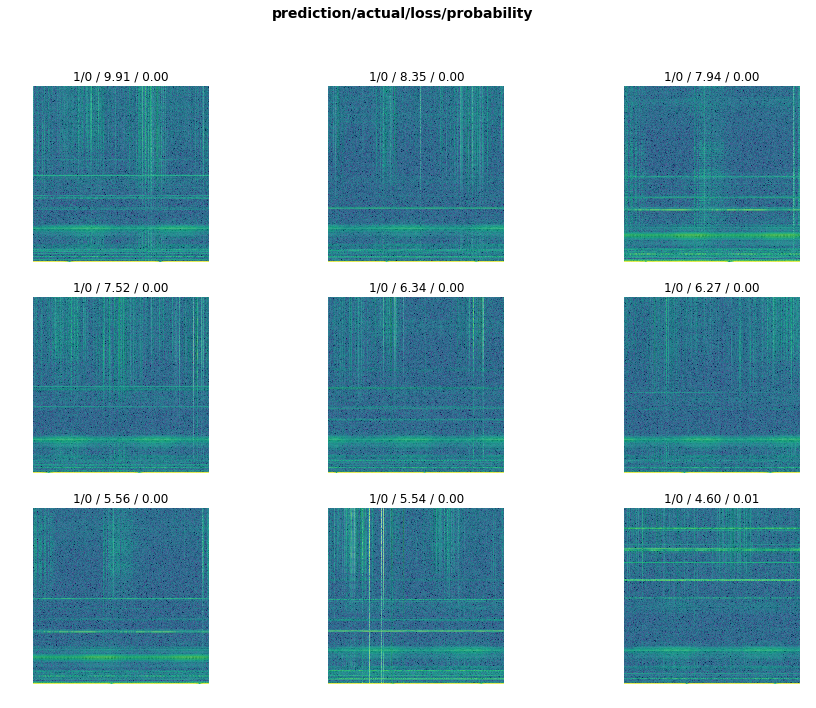

In [40]:
interp.plot_top_losses(9, figsize=(15,11))

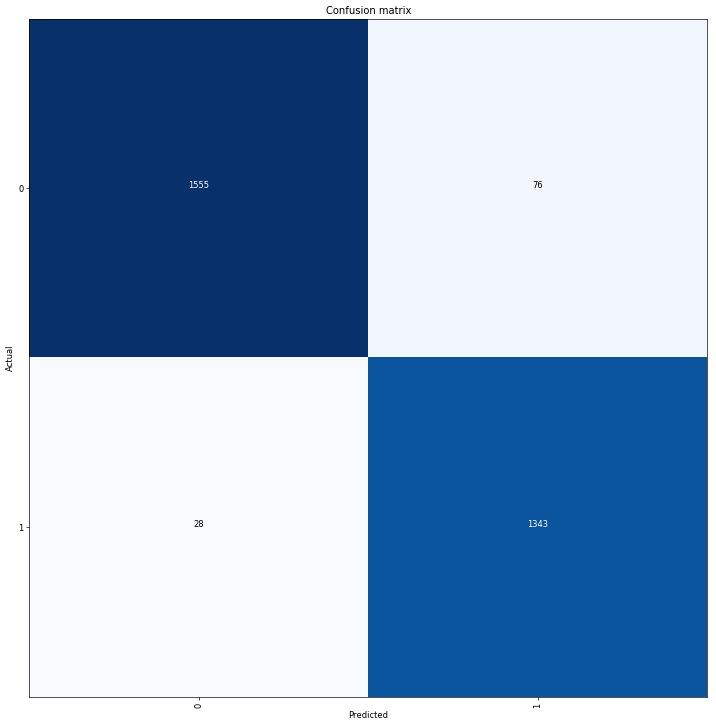

In [41]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [42]:
interp.most_confused(min_val=2)

[(0, 1, 76), (1, 0, 28)]

## Unfreezing, fine-tuning, and learning rates

sequence used when restarting NB here

restart NB

learn = create_cnn()

lean.model = dataparallel

learn.load

learn.unfreeze

learn.find

In [47]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [48]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [49]:
learn.load(f'{MODEL_NAME}_stage-1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12010 items)
[Category 0, Category 0, Category 0, Category 1, Category 0]...
Path: ../input/train_600_ts_aug_viridis-60_10
x: ImageItemList (12010 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-60_10;

Valid: LabelList
y: CategoryList (3002 items)
[Category 1, Category 1, Category 0, Category 1, Category 1]...
Path: ../input/train_600_ts_aug_viridis-60_10
x: ImageItemList (3002 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-60_10;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
 

In [50]:
learn.unfreeze()

In [51]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


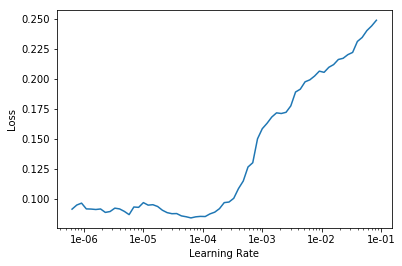

In [52]:
learn.recorder.plot()

See Hiromi's excellent fastai notes lesson 3 for fit_one_cycle notes:
    https://github.com/hiromis/notes/blob/master/Lesson3.md

In [53]:
learn.fit_one_cycle(5, slice(5e-6, lr/5))

epoch,train_loss,valid_loss,error_rate
1,0.079841,0.092799,0.028648
2,0.075999,0.073283,0.023318
3,0.036084,0.058580,0.020320
4,0.012690,0.052073,0.015323
5,0.006309,0.049790,0.014657


In [54]:
learn.save(f'{MODEL_NAME}_stage-2_unfeeze')

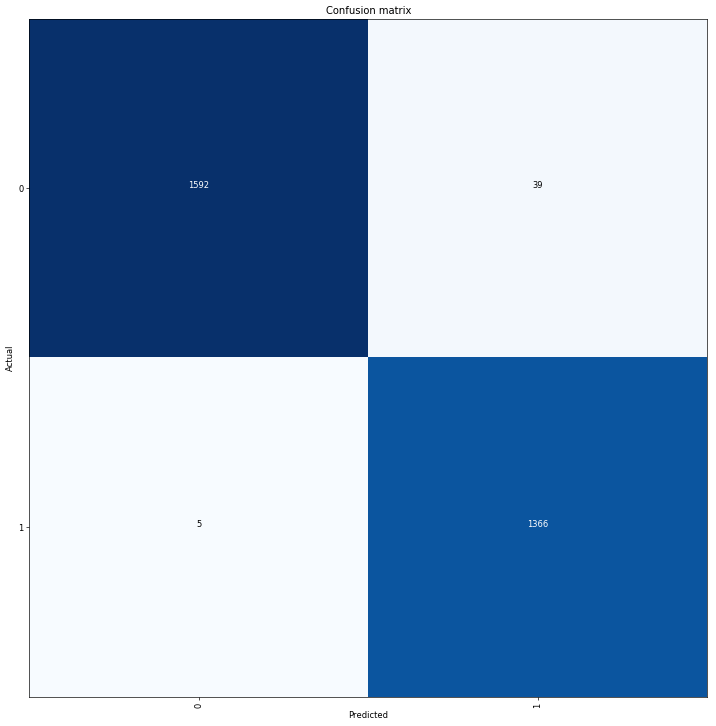

In [70]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



In [66]:
df_val = train_df.sample(frac=0.2)
val_idxs=df_val.index.values

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [67]:
image_size

600

In [68]:
#data = ImageDataBunch.from_df(train_path, train_df, fn_col=0, label_col=3, ds_tfms=tfms, size=image_size, suffix='.jpg', bs=bs).normalize(imagenet_stats)

In [69]:
data = (ImageItemList.from_df(train_df, path=train_path, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs)).normalize(imagenet_stats)

In [87]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [88]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [89]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


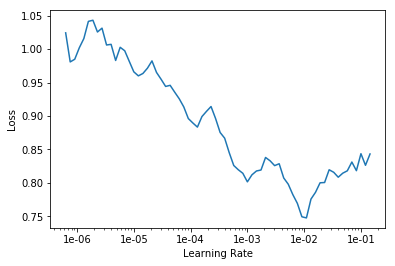

In [90]:
learn.recorder.plot()

<pre>
lr = 1e-4

learn.fit_one_cycle(5, slice(lr))
epoch 	train_loss 	valid_loss 	error_rate
1 	0.684954 	0.510938 	0.224517
2 	0.634790 	0.380567 	0.174883
3 	0.617487 	0.347769 	0.131912
4 	0.553024 	0.353468 	0.137908
5 	0.549290 	0.325940 	0.113924

lr = 1e-4

learn.fit_one_cycle(5, lr)
epoch 	train_loss 	valid_loss 	error_rate
1 	0.690730 	0.346024 	0.142572
2 	0.545960 	0.352419 	0.154231
3 	0.569328 	0.359911 	0.160560

learn.fit_one_cycle(5, max_lr=slice(3e-5,6e-4))
epoch 	train_loss 	valid_loss 	error_rate
1 	0.386519 	0.283372 	0.116803
2 	0.289095 	0.224292 	0.099385
3 	0.417320 	0.210221 	0.089139
4 	0.340808 	0.263518 	0.118852
5 	0.378957 	0.259912 	0.114242


learn.fit_one_cycle(5, 1e-3) 2x
epoch 	train_loss 	valid_loss 	error_rate
1 	0.614866 	0.411516 	0.189540
2 	0.586948 	0.422885 	0.174550
3 	0.594937 	0.540298 	0.265490
4 	0.536863 	0.381666 	0.133911
5 	0.515296 	0.363290 	0.135243
epoch 	train_loss 	valid_loss 	error_rate
1 	0.592092 	0.410098 	0.150233
2 	0.615428 	0.451473 	0.170553
3 	0.604227 	0.455074 	0.147568
4 	0.573704 	0.362872 	0.133578
5 	0.563021 	0.389852 	0.142239

learn.fit_one_cycle(15, slice(6e-3))
epoch 	train_loss 	valid_loss 	error_rate
1 	0.538124 	0.366921 	0.157562
2 	0.566328 	0.350847 	0.143238
3 	0.583983 	0.877807 	0.199867
4 	0.589272 	11.739514 	0.304797
5 	0.601694 	2.163939 	0.208528
6 	0.595242 	7.422735 	0.232512
7 	0.616678 	1.296340 	0.172552
8 	0.574509 	2.631071 	0.299134
9 	0.524232 	0.704787 	0.151899
10 	0.532725 	1.581566 	0.148901
11 	0.531184 	1.011814 	0.191206
12 	0.512880 	3.741719 	0.203864
13 	0.525075 	12.605072 	0.230513
14 	0.534637 	2.514722 	0.234510
15 	0.511561 	3.185054 	0.185210

</pre>

In [91]:
learn.fit_one_cycle(5, slice(5e-3))

epoch,train_loss,valid_loss,error_rate
1,0.449609,0.864837,0.363492
2,0.429203,0.521854,0.267601
3,0.392369,0.493414,0.189232
4,0.343272,12.585844,0.243708
5,0.364568,0.682607,0.255177


In [ ]:
learn.recorder.plot_losses()

In [98]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [99]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


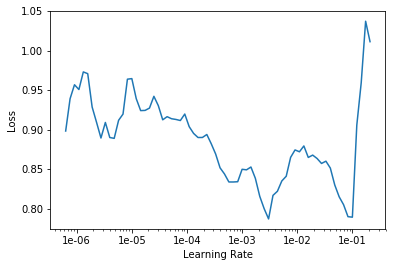

In [100]:
learn.lr_find()
learn.recorder.plot()


In [101]:
learn.fit_one_cycle(1, slice(2e-4))

epoch,train_loss,valid_loss,error_rate
1,0.411347,0.575252,0.272380


In [102]:
learn.save(f'{MODEL_NAME}_aug_stage-1_1x2e4-50_{DATE}')

In [103]:
learn.fit_one_cycle(1, slice(2e-4))

epoch,train_loss,valid_loss,error_rate
1,0.383658,0.457698,0.233514


In [104]:
learn.save(f'{MODEL_NAME}_aug_stage-1_2x2e4-50_{DATE}')

In [105]:
learn.fit_one_cycle(1, slice(2e-4))

epoch,train_loss,valid_loss,error_rate
1,0.394931,0.588635,0.275565


In [106]:
learn.save(f'{MODEL_NAME}_aug_stage-1_3x2e4-50_{DATE}')

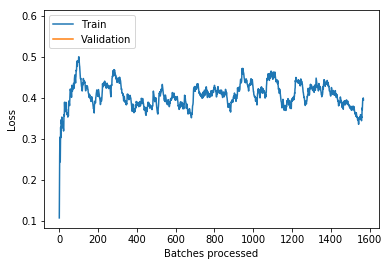

In [107]:
learn.recorder.plot_losses()

In [130]:
import pdb

#### Early stopping if loss doesnt improve

In [135]:
class EarlyStopping(LearnerCallback):
    "A `LearnerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self, 
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 mode='auto'):
        
        super().__init__(learn)
        
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.mode = mode
        if mode not in ['auto', 'min', 'max']:
            #should I use warning?
            print(f'TerminateEarly mode {mode} is invalid, falling back to "auto" mode.')
            mode = 'auto'
        if mode == 'min':
            self.operator = np.less
        elif mode == 'max':
            self.operator = np.greater
        else:
            if 'loss' in self.monitor:
                self.operator = np.less
            else:
                self.operator = np.greater
        if self.operator == np.less:
            self.min_delta *= -1
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.wait = 0
        self.stopped_epoch = 0
        self.best = float('inf') if self.operator == np.less else -float('inf')

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        current = self.get_monitor_value()
        if current is None:
            return
         
        if self.operator(current - self.min_delta, self.best):
            
            self.best = current
            self.wait = 0
        else:
            
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                return True
        return False
                
    def on_train_end(self, **kwargs:Any)->None:
        if self.stopped_epoch > 0:
            print(f'Epoch {self.stopped_epoch}: early stopping')
                                                                          
    def get_monitor_value(self):
        if len(learn.recorder.val_losses)>0 and len(learn.recorder.losses)>0:
            values = {'val_loss':learn.recorder.val_losses[-1:][0]
                   ,'trn_loss':learn.recorder.losses[-1:][0].cpu().numpy()}
            for i, name in enumerate(learn.recorder.names[3:]):
                values[name]=learn.recorder.metrics[-1:][0][i] 

            if values.get(self.monitor) is None:
                print(f'Early stopping conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, learn.recorder.names[3:]))}')   
            return values.get(self.monitor)
        return None

In [136]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, callbacks=[EarlyStopping(monitor='accuracy', min_delta=0.01, patience=3)])

In [137]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


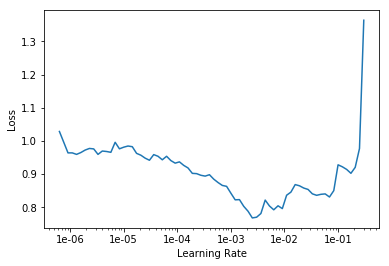

In [138]:
learn.lr_find()
learn.recorder.plot()


In [ ]:
'''
fit_one_cycle(cyc_len=5, max_lr=defaults.lr,
                  moms=(0.95,0.85), div_factor=25., pct_start=0.3,
                  wd=None)
'''

In [139]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3), callbacks=[EarlyStopping(monitor='accuracy', min_delta=0.01, patience=3)] )

epoch,train_loss,valid_loss,error_rate
1,0.422167,0.298783,0.116916
2,0.422215,0.478316,0.245620
3,0.347846,0.505243,0.233195
4,0.362395,0.768665,0.308060
5,0.327121,0.584809,0.250717


Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy` which is not available. Available metrics are: error_rate
Early stopping conditioned on metric `accuracy

In [140]:
class SaveModel(LearnerCallback):
    "A `LearnerCallback` that terminates training when monitored quantity stops improving."
    def __init__(self,
                 monitor='val_loss',
                 every = 'improvement',
                 mode='auto'):
        
        super().__init__(learn)
        
        self.monitor = monitor
        self.every = every
        self.mode = mode
        if every not in ['improvement', 'epoch']:
            #should I use warning?
            print(f'SaveModel every {every} is invalid, falling back to "improvement".')
            every = 'improvement'
        
        if mode not in ['auto', 'min', 'max']:
            #should I use warning?
            print(f'SaveModel mode {mode} is invalid, falling back to "auto" mode.')
            mode = 'auto'
        if mode == 'min':
            self.operator = np.less
        elif mode == 'max':
            self.operator = np.greater
        else:
            if 'loss' in self.monitor:
                self.operator = np.less
            else:
                self.operator = np.greater
   
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch":
            filename = f'model__epoch{epoch}'
            learn.save(filename)
            return 
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is None:
                return
            if self.operator(current, self.best):
                self.best = current
                filename = f'bestmodel_epoch{epoch}'
                learn.save(filename)
            return 
                                                                          
    def get_monitor_value(self):
        values = {'val_loss':learn.recorder.val_losses[-1:][0]
               ,'trn_loss':learn.recorder.losses[-1:][0].cpu().numpy()}
        for i, name in enumerate(learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 

        if values.get(self.monitor) is None:
            print(f'Early stopping conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, learn.recorder.names[3:]))}')   
        return values.get(self.monitor)


In [142]:
learn = create_cnn(data, models.resnet50, metrics=[error_rate], callbacks=[SaveModel(every='epoch')])

In [143]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


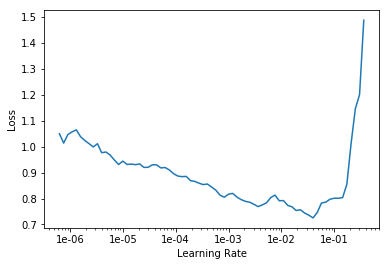

In [144]:
learn.lr_find()
learn.recorder.plot()


In [145]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.402319,0.342071,0.146225
2,0.394018,0.442485,0.216630
3,0.318037,0.334693,0.149729
4,0.336355,0.460173,0.222364
5,0.344782,0.569611,0.247531


## Densenet

In [146]:
from torchvision.models import densenet121

In [147]:
learn = create_cnn(data, densenet121, metrics=[error_rate])

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/walle/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:05<00:00, 5845992.56it/s]


In [148]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


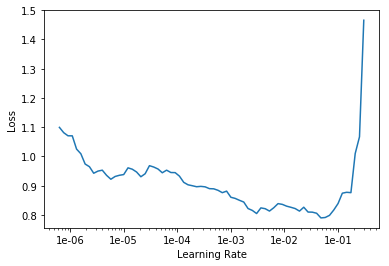

In [149]:
learn.lr_find()
learn.recorder.plot()

In [150]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.404544,0.269203,0.099076
2,0.395487,0.261317,0.096209
3,0.336282,0.259196,0.105448
4,0.358612,0.256720,0.086970
5,0.332084,0.252830,0.079325


In [151]:
learn.save(f'{MODEL_NAME}_aug_stage-1_dn121_{DATE}')

In [152]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.335946,0.239432,0.072316
2,0.298339,0.248762,0.090156
3,0.321821,0.221366,0.059892
4,0.260374,0.206668,0.062440
5,0.286072,0.204247,0.063396


In [153]:
learn.save(f'{MODEL_NAME}_aug_stage-1-1_dn121_{DATE}')

In [154]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,error_rate
1,0.303652,0.209009,0.061166
2,0.325268,0.202550,0.060529
3,0.335047,0.235522,0.063077
4,0.266356,0.216865,0.061485
5,0.268174,0.213009,0.065307


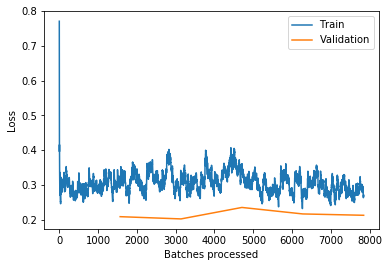

In [156]:
learn.recorder.plot_losses()

In [155]:
learn.load(f'{MODEL_NAME}_aug_stage-1_dn121_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12557 items)
[Category 0, Category 0, Category 1, Category 1, Category 0]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (12557 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Valid: LabelList
y: CategoryList (3139 items)
[Category 0, Category 0, Category 1, Category 1, Category 1]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (3139 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

### unfreeze

In [157]:
learn.unfreeze()


In [158]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


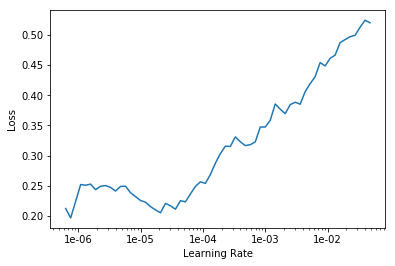

In [159]:
learn.recorder.plot()

In [160]:
learn.fit_one_cycle(3, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.332745,0.215007,0.071679
2,0.366171,0.233327,0.077413
3,0.310426,0.229273,0.084422


In [161]:
learn.save(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')

In [162]:
interp = ClassificationInterpretation.from_learner(learn)

In [163]:
interp.most_confused(min_val=2)

[(0, 1, 196), (1, 0, 69)]

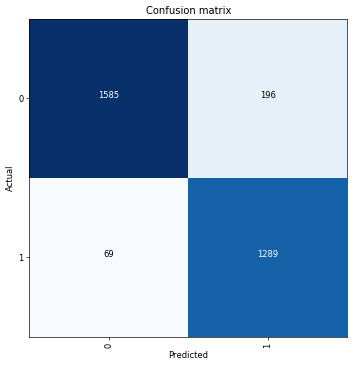

In [167]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

### Predict

In [168]:
test_images = glob.glob(str(test_path)+"/*.jpg")

In [169]:
learn.load(f'{MODEL_NAME}_aug_stage-2_dn121_{DATE}')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (12557 items)
[Category 0, Category 0, Category 1, Category 1, Category 0]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (12557 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Valid: LabelList
y: CategoryList (3139 items)
[Category 0, Category 0, Category 1, Category 1, Category 1]...
Path: ../input/train_600_ts_aug_viridis-70-20
x: ImageItemList (3139 items)
[Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600), Image (3, 600, 600)]...
Path: ../input/train_600_ts_aug_viridis-70-20;

Test: None, model=DataParallel(
  (module): Sequential(
    (0): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [170]:
d={}
for i,fname in enumerate(test_images):
    im_name=fname.split('/')[3]
    signal_id = im_name[:im_name.index(".")]
    img = open_image(test_images[i])
    cat, val, probs=learn.predict(img)
    d[signal_id]=cat.__str__()
    #print(f'signal_id: {signal_id}, cat: {cat.__str__()}, val: {val}')

In [171]:
df_sub_dn121_u=pd.DataFrame.from_dict(d, orient='index')

In [172]:
df_sub_dn121_u=df_sub_dn121_u.reset_index()


In [173]:
df_sub_dn121_u.rename(columns={'index': 'signal_id', 0: 'target'}, inplace=True)
df_sub_dn121_u.head()

,signal_id,target
0,8847,0
1,25536,1
2,24202,0
3,11043,0
4,25522,0


In [174]:
df_sub_dn121_u.to_csv(path/f'submissions/submission_aug_densenet121_unfeeze-2_{DATE}_{UID}.csv', index=False)

In [ ]:
#submission 9 0.363
#worst submission yet !!!
